In [43]:
# import pandas as pd
# import os

# filename = 'train.csv'
# if os.path.exists(filename):
#     os.remove(filename)

# month = ['03', '04']
# flag = True
# for i in month:
#     taxi = pd.read_csv(r'D:/Application/eclipse/workspace/COMSE6998PROJECT//PreProcessTaxiData/cleanData_yellow_tripdata_2016-%s.csv'%i)
#     del taxi['Unnamed: 0']

#     # remove weekends
#     taxi['tpep_pickup_datetime1'] = pd.to_datetime(taxi['tpep_pickup_datetime'])
#     taxi['weekday'] = taxi['tpep_pickup_datetime1'].dt.dayofweek
#     taxi = taxi[taxi['weekday'] <= 4]
#     del taxi['weekday']
#     del taxi['tpep_pickup_datetime1']
    
#     Time=taxi['tpep_pickup_datetime'].copy().str.slice(8,16)
#     taxi['tpep_pickup_datetime']=Time.str.slice_replace(6,8,'51')
#     # column name外面最好加中括号
#     taxiDate = taxi[['tpep_pickup_datetime']].copy()
#     countPickup = taxiDate['tpep_pickup_datetime'].value_counts()
#     countPickup = countPickup.sort_index().to_frame()
#     countPickup.index.names=['Time']
#     countPickup.rename(columns={'tpep_pickup_datetime':'pickup_number'}, inplace = True)
#     countPickup.index = countPickup.index.str.slice(3,5)
#     # 只需要一个header
#     if flag:
#         countPickup.to_csv('train.csv', mode='a', header=True)
#         flag = False
#         continue
#     countPickup.to_csv('train.csv', mode='a', header=False)

In [42]:
# import pandas as pd
# import os

# filename = 'weather.csv'
# if os.path.exists(filename):
#     os.remove(filename)

# month = ['03', '04']
# flag = True
# for i in month:
#     weather = pd.read_csv(r'D:/Application/eclipse/workspace/COMSE6998PROJECT/WeatherCrawler/weather_processed_again/weather_2016_%s.csv'%i,index_col='Time')
    
#     # remove weekends
#     weather['tpep_pickup_datetime'] = list(pd.to_datetime(pd.Series(['2016-%s-'%i for x in range(len(weather.index))]).str.cat(list(weather.index)),format='%Y-%m-%d %H:%M'))    
#     weather['weekday'] = weather['tpep_pickup_datetime'].dt.dayofweek
#     weather = weather[weather['weekday'] <= 4]
#     del weather['weekday']
#     del weather['tpep_pickup_datetime']
    
#     weather.index = weather.index.str.slice(3,5)
#     # 只需要一个header
#     if flag:
#         weather.to_csv('weather.csv', mode='a', header=True)
#         flag = False
#         continue
#     weather.to_csv('weather.csv', mode='a', header=False)

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import ShuffleSplit
from sklearn.externals import joblib
from sklearn import svm
from sklearn import decomposition
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from time import time
import json
import os
# The usual preamble
%matplotlib inline
import matplotlib.pyplot as plt

# Make the graphs a bit prettier, andigger
pd.set_option('display.mpl_style', 'default')
plt.rcParams['figure.figsize'] = (15, 5)

D:\Application\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Application\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2882: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# #############################################################################
def train(filename):

    # #############################################################################
    # load data
    df = pd.read_csv(filename)
    if './location' in filename:
        filename = filename.split('/')[2]
    weather = pd.read_csv('weather.csv')
    df = weather.join(df[['pickup_number']])
    # 重新设置index，因为拼接时index会重复
    df.index = pd.Series(range(0,len(df)))
    df['Time'] = df['Time'].astype('str')
    X = df[['Weather','Time']].copy()
    # series to list: X.tolist()
    test_num = 120 # for the situation where weekends are removed

    # #############################################################################
    # Normalization
    y = df['pickup_number'].astype('float')
    y = np.array(y)
    y_min = y.min()
    y_max = y.max()
    y -= y_min
    y /= y_max
    # plot pickup_number of the test data
    plt.plot(list(df.index)[-test_num:], list(df['pickup_number'])[-test_num:])
    plt.scatter(list(df.index)[-test_num:], list(df['pickup_number'])[-test_num:])
    plt.xlabel('time_by_hour')
    plt.ylabel('pickup_number')
    plt.savefig("pickup_number.jpg")  
    
    # remove useless columns
    del df['Time']
    del df['Weather']
    del df['pickup_number']

    # #############################################################################
    # Normalization
    df.astype('float')
    data = np.array(df)
    x_min = data.min()
    x_max = data.max()
    data -= x_min
    data /= x_max
    data = pd.DataFrame(data)
    # column names of data: Temp    Wind    Humidity    Barometer   Visibility

    # #############################################################################
    # vectorization
    X = [X.loc[index].to_dict() for index in X.index]
    if os.path.exists(r'./models/vec.pkl'):
        vec = joblib.load(r'./models/vec.pkl')
        dummyX = vec.transform(X).toarray()
    else:
        vec = DictVectorizer()    
        dummyX = vec.fit_transform(X).toarray()
        joblib.dump(vec, r'models/vec.pkl')
    # print str(dummyX)
    # print(vec.get_feature_names())
    X = pd.DataFrame(dummyX,columns=vec.get_feature_names())    
    X = data.join(X)
    X = np.array(X)
    
#     def pca(tdm, n_components):
#         pca = decomposition.PCA(n_components=n_components)
#         pca.fit(tdm)
#         reducedTDM = pca.transform(tdm)  # reduced tdm distance matrix

#     #     with open('pca.pk', 'wb') as fin:
#     #         pickle.dump(self.pca, fin)
#         return reducedTDM
    
#     X = pca(X,0.99)
    
    # print X.shape # (744L, 58L)
    # print y.shape # (744L,)

    # #############################################################################
    # split train samples and test samples
    # X_train, X_test, y_train, y_test = train_test_split(X, y)
    X_train, X_test, y_train, y_test = X[:-test_num], X[-test_num:], y[:-test_num], y[-test_num:]
    y_test = y_test*y_max+y_min
    # print X_train.shape # (558L, 58L)
    # print y_train.shape # (558L,)

    # #############################################################################
    # grid search

    # r2_socre用来度量未来的样本是否可能通过模型被很好地预测
    def gridSearchCV(clf, param_grid,score=make_scorer(r2_score)):
        # scoring = {'evc': make_scorer(explained_variance_score), 'r2_score': make_scorer(r2_score), 'mse': make_scorer(mean_squared_error)}
        grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=score)
        start = time()
        grid_search.fit(X_train, y_train)
        bestScore = round(grid_search.best_score_, 4)
        parameters = grid_search.best_params_
#         print("Best Score: " + str(bestScore) + "\nParameters: " + str(parameters))
        return bestScore, parameters

    # return the optimal model
    def optFunc(theModel,theParams):
        tempParam = list()
        for key, value in theParams.iteritems():
            if isinstance(value, str):
                tempParam.append(str(key) + "='" + value + "'") 
                continue
            tempParam.append(str(key) + "=" + str(value)) 
        theParams = ",".join(tempParam)
        return eval(theModel + theParams + ")")

    # #############################################################################
    # Fit regression model

#     # SVR rbf kernel
#     svr_rbf = svm.SVR(kernel='rbf')
#     param_grid = {"C": [1, 10, 100, 1000], "gamma": np.logspace(-2, 2, 5)}
#     svr_rbf_score, parameters = gridSearchCV(svr_rbf, param_grid)
#     svr_rbf = optFunc('svm.SVR(kernel="rbf", ', parameters)

#     # SVR linear kernel
#     svr_lin = svm.SVR(kernel='linear')
#     param_grid = {"C": [1, 10, 100, 1000]}
#     svr_lin_score, parameters = gridSearchCV(svr_lin, param_grid)
#     svr_lin = optFunc('svm.SVR(kernel="linear", ', parameters)

#     # SVR polynomial kernel
#     svr_poly = svm.SVR(kernel='poly')
#     param_grid = {"C": [1, 10, 100, 1000], "degree": [1, 2, 3]}
#     svr_poly_score, parameters = gridSearchCV(svr_poly, param_grid)
#     svr_poly = optFunc('svm.SVR(kernel="poly", ', parameters)

#     # Gradient Boosting regression
#     gbr = GradientBoostingRegressor()
#     param_grid = {'n_estimators': [500, 700, 900], 'max_depth': [1, 2], 'min_samples_split': [2], 
#               'learning_rate': [0.01, 0.1], 'loss': ['lad']}
#     gbr_score, parameters = gridSearchCV(gbr, param_grid)
#     gbr = optFunc('GradientBoostingRegressor(', parameters)

    # kernel ridge regression
    krr = KernelRidge(kernel='rbf')
    param_grid = {"alpha": [1e0, 1e-1, 1e-2, 1e-3], "gamma": np.logspace(-2, 2, 5)}
    krr_score, parameters = gridSearchCV(krr, param_grid)
    krr = optFunc('KernelRidge(kernel="rbf", ', parameters)
    
#     # LinearRegression
#     lr = LinearRegression()
#     lr_score = -100
# #     print("Best Score: " + str(lr_score) + "\nParameters: ")
    
#     # DecisionTreeRegressor
#     dtr = DecisionTreeRegressor()
#     param_grid = {'max_depth': [2, 4, 6, 8]}
#     dtr_score, parameters = gridSearchCV(dtr, param_grid)
#     dtr = optFunc('DecisionTreeRegressor(', parameters)
    
#     # KNeighborsRegressor
#     knr = KNeighborsRegressor()
#     param_grid = {'n_neighbors': [2, 4, 6, 8]}
#     knr_score, parameters = gridSearchCV(knr, param_grid)
#     knr = optFunc('KNeighborsRegressor(', parameters)
    
#     # RandomForestRegressor
#     rfr = RandomForestRegressor()
#     param_grid = {'max_depth': [2, 4, 6, 8], 'n_estimators': [20, 50, 150, 500]}
#     rfr_score, parameters = gridSearchCV(rfr, param_grid)
#     rfr = optFunc('RandomForestRegressor(', parameters)
    
#     # AdaBoostRegressor
#     adr = AdaBoostRegressor()
#     param_grid = {'n_estimators': [20, 50, 150, 500]}
#     adr_score, parameters = gridSearchCV(adr, param_grid)
#     adr = optFunc('AdaBoostRegressor(', parameters)
    
#     # BaggingRegressor
#     br = BaggingRegressor()
#     param_grid = {'n_estimators': [20, 50, 150, 500]}
#     br_score, parameters = gridSearchCV(br, param_grid)
#     br = optFunc('BaggingRegressor(', parameters)

    # #############################################################################
    # select model with minimized mse and save model
#     models = [(svr_rbf,'SVR rbf kernel'),(svr_lin,'SVR linear kernel'),(svr_poly,'SVR polynomial kernel'),\
#               (gbr,'Gradient Boosting regression'),(krr,'kernel ridge regression'),(lr,'LinearRegression'),\
#              (dtr,'DecisionTreeRegressor'),(knr,'KNeighborsRegressor'), (rfr,'RandomForestRegressor'),\
#              (adr,'AdaBoostRegressor'),(br,'BaggingRegressor')]
#     scores = [svr_rbf_score, svr_lin_score, svr_poly_score, gbr_score, krr_score, lr_score, dtr_score,\
#               knr_score, rfr_score, adr_score, br_score]
    
#     index = max(enumerate(scores),key=lambda x: x[1])[0]
#     model = models[index][0]
#     modelName = models[index][1]
#     print 'model: ' + modelName

    model = krr
    modelName = 'kernel ridge regression'

#     # #############################################################################
#     # Visualize learning curves
#     def plot_learning_curve(model, modelName):
#         train_sizes, train_scores, test_scores = learning_curve(estimator=model, X=X_train, y=y_train, \
#                                                                 train_sizes=np.linspace(0.1, 1.0, 10), cv=5, n_jobs=4)
#         train_mean = np.mean(train_scores, axis=1)
#         train_std = np.std(train_scores, axis=1)
#         test_mean = np.mean(test_scores, axis=1)
#         test_std = np.std(test_scores, axis=1)

#         # plot in a new graph
#         plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training score')
#         plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
#         plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation score')
#         plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
#         plt.grid(True)
#         plt.xlabel('Number of training samples')
#         plt.ylabel('Score')
#         plt.title('Learning Curves (%s)'%modelName)
#         plt.legend(loc='best')

#     # #############################################################################
#     # plor the result
#     def plot_result(y_pred, modelName):
#         x = range(0, len(y_test))
#         plt.scatter(x, y_test, color='darkorange', label='Ground truth')
#         plt.scatter(x, y_pred, color='navy')
#         plt.plot(x, y_pred, color='navy', label='Predict value')
#         plt.title(modelName)
#         plt.xlabel('time_by_hour')
#         plt.ylabel('pickup_number')
#         plt.legend()
                            
#     # #############################################################################
#     # Predict on test samples
#     plt.figure()
#     plt.subplot(1, 2, 1)
#     plot_learning_curve(model, modelName)

    # fit the model on train samples
    model.fit(X_train, y_train)

    # save the model
    joblib.dump(model, r'models/' + filename[:-4] + '.pkl')
    dic = {'y_max':y_max, 'y_min':y_min, 'x_max':x_max, 'x_min':x_min}
    with open(r'models/' + filename[:-4] + '_coefficient.js','w') as f:
        json.dump(dic, f)

#     plt.subplot(1, 2, 2)
#     plot_result(model.predict(X_test)*y_max+y_min, modelName)
#     plt.show()

#     for each in models:
#         plt.figure()
#         plt.subplot(1, 2, 1)
#         plot_learning_curve(each[0], each[1])
#         each[0].fit(X_train, y_train)
#         plt.subplot(1, 2, 2)
#         plot_result(each[0].predict(X_test)*y_max+y_min, each[1])
#         plt.show()
        
#     # scale the result and plot
#     yy = y_pred
#     yyy = (1 - (max(yy)-yy)/(max(yy)-min(yy)))*24000

#     plt.scatter(x, y_test, color='darkorange', label='data')
#     plt.scatter(x, yyy, color='navy')
#     plt.plot(x, yyy, color='navy', label=modelName)
#     # 对应点相连
#     # plt.plot([a.index, a.index], [y_test, yyy*25000], color='blue', linewidth=2.5, linestyle="--")
#     plt.xlabel('data')
#     plt.ylabel('target')
#     plt.legend()
#     plt.show()

12760
12770
12780
12790
12800
12810
12820
12830
12840
12850
12860
12870
12880
12890
12900
12910
12920
12930
12940
12950
12960
12970
12980
12990
13000
13010
13020
13030
13040
13050


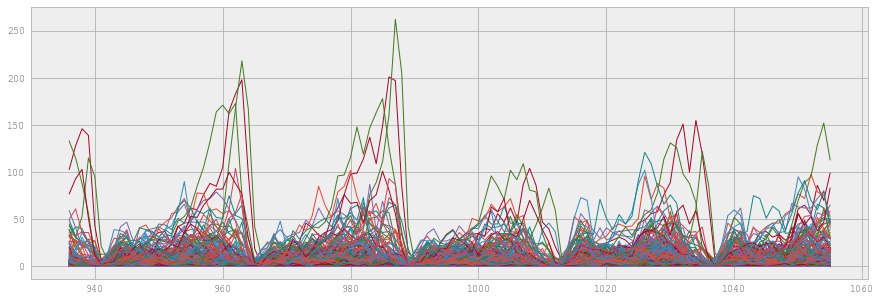

In [5]:
import os
import traceback

count = 0 # 0-9490都处理完了，9490-12750是满足判断条件的点
path = './location/'
for f in os.listdir(path):
    if count <= 9490:
        count += 1
        continue
    location = f[:-4]
    longitude, latitude = location.split(',')
    if float(longitude)>-74.011 and float(longitude)<-73.946 and float(latitude)<40.786 and float(latitude)>40.719:
        if count <= 12750:
            count += 1
            continue
        try:
            train(path+f)
            count += 1
            if count % 10 == 0:
                print count
        except Exception:
            print traceback.print_exc()

Best Score: 0.9144
Parameters: {'C': 100, 'gamma': 0.01}
Best Score: 0.9153
Parameters: {'C': 1}
Best Score: 0.9151
Parameters: {'C': 1000, 'degree': 1}
Best Score: 0.9315
Parameters: {'min_samples_split': 2, 'loss': 'lad', 'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 1}
Best Score: 0.9333
Parameters: {'alpha': 0.01, 'gamma': 0.01}
Best Score: -100
Parameters: 
Best Score: 0.849
Parameters: {'max_depth': 8}
Best Score: 0.7413
Parameters: {'n_neighbors': 6}
Best Score: 0.868
Parameters: {'n_estimators': 150, 'max_depth': 8}
Best Score: 0.5419
Parameters: {'n_estimators': 500}
Best Score: 0.9271
Parameters: {'n_estimators': 150}
model: kernel ridge regression


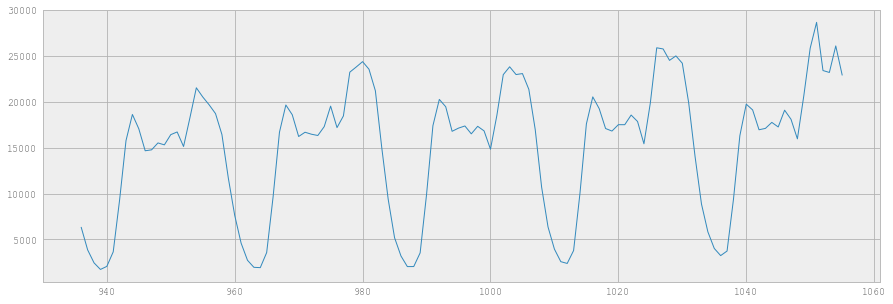

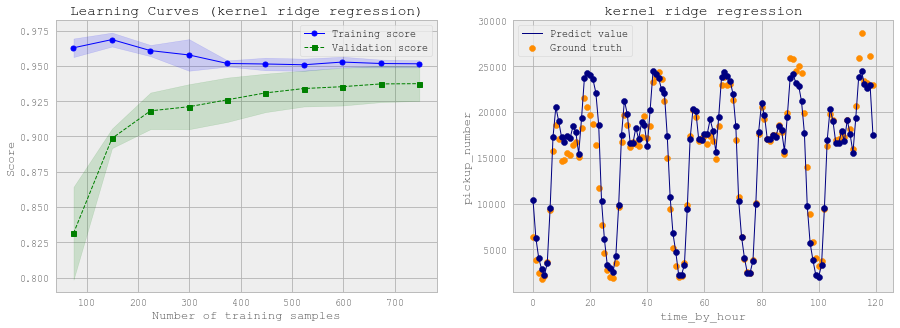

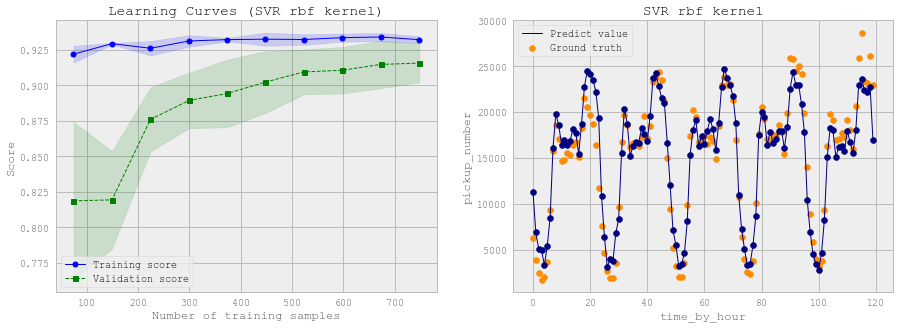

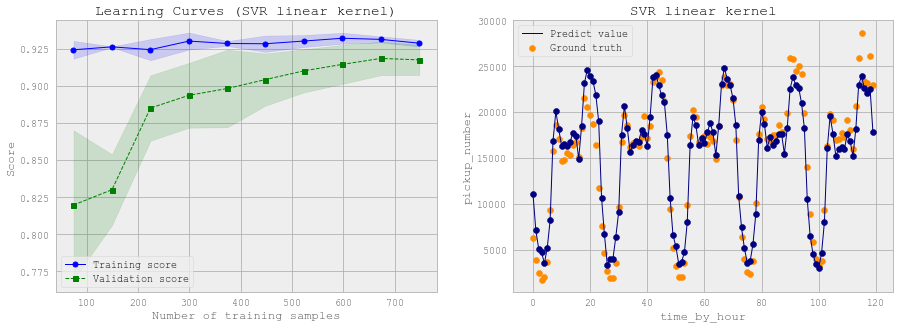

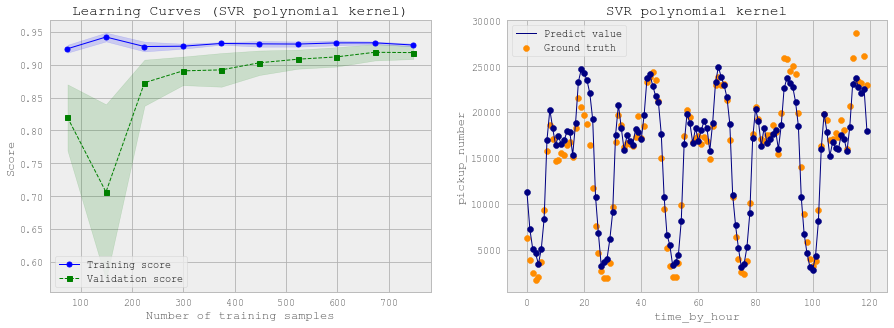

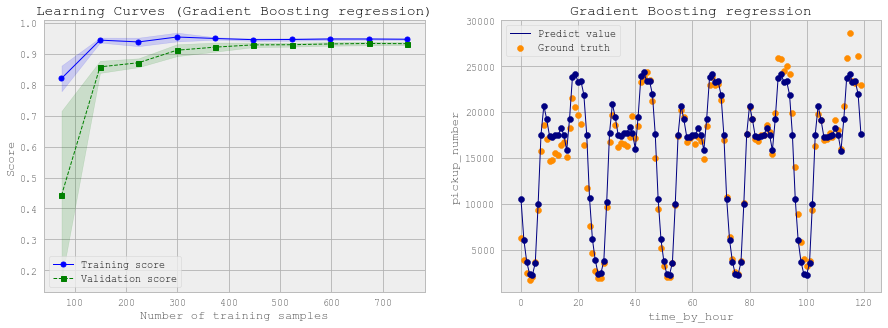

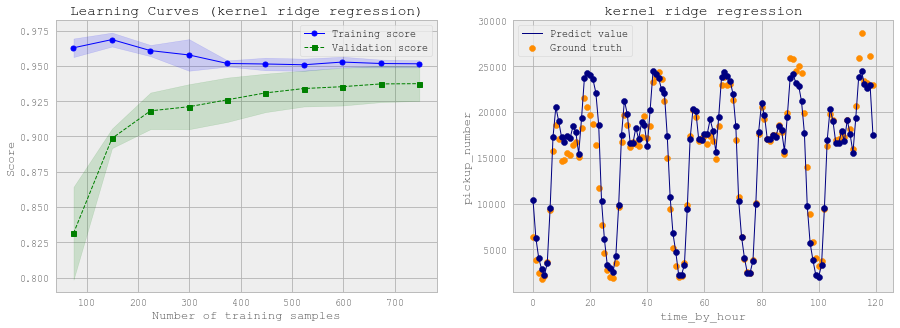

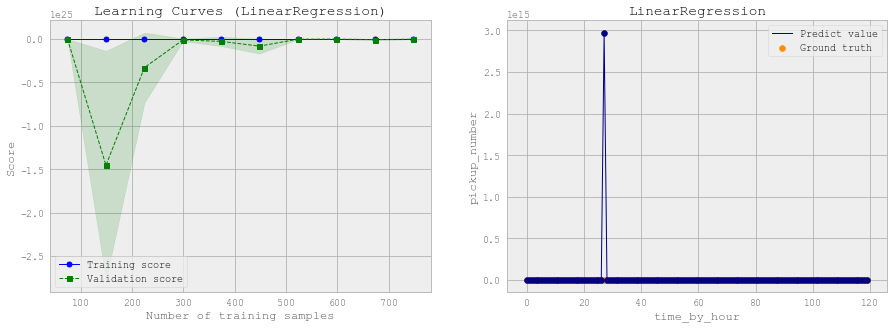

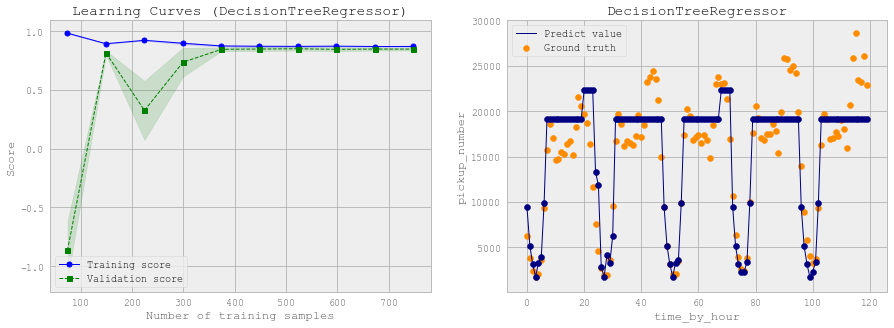

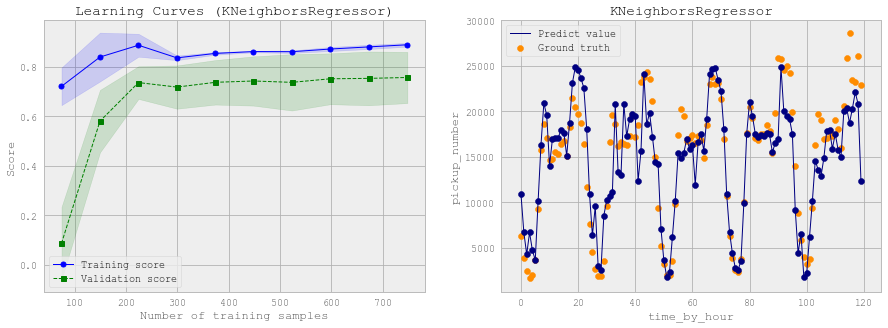

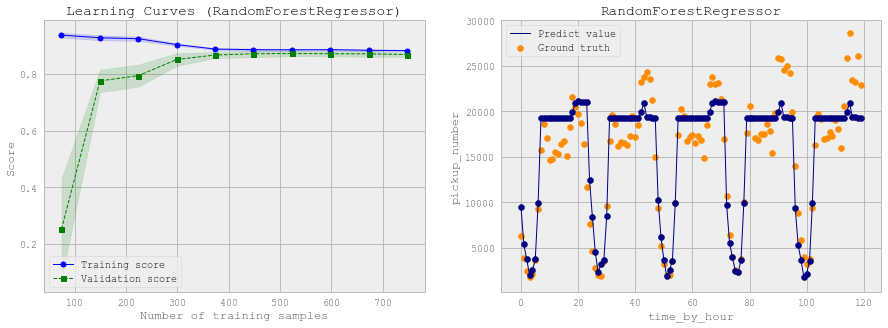

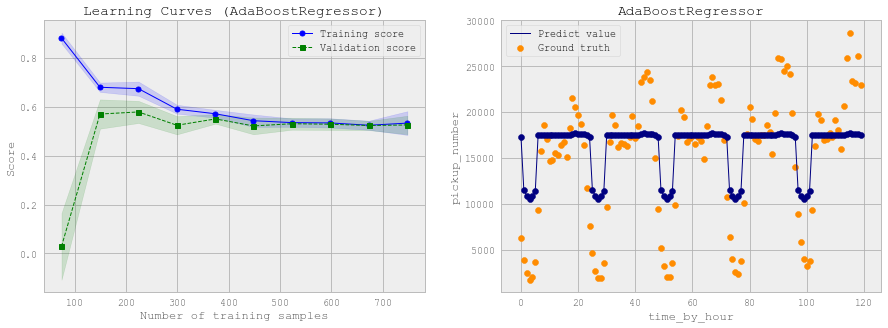

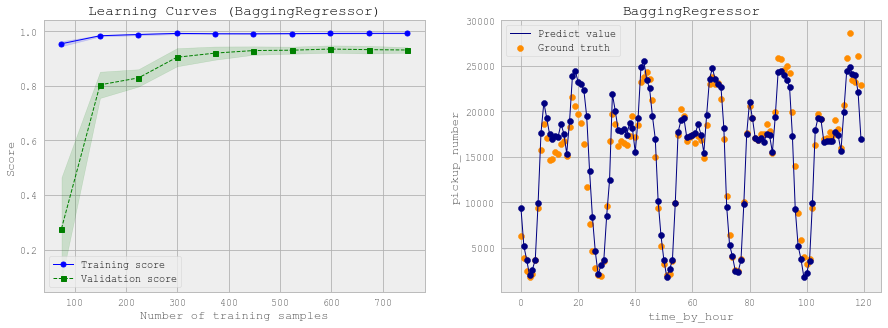

In [47]:
# train('train.csv')

Best Score: 0.3766
Parameters: {'C': 10, 'gamma': 0.01}
Best Score: 0.3739
Parameters: {'C': 1}
Best Score: 0.3762
Parameters: {'C': 10, 'degree': 1}
Best Score: 0.2933
Parameters: {'min_samples_split': 2, 'loss': 'lad', 'learning_rate': 0.1, 'n_estimators': 700, 'max_depth': 2}
Best Score: 0.3777
Parameters: {'alpha': 0.1, 'gamma': 0.01}
Best Score: -100
Parameters: 
Best Score: 0.1398
Parameters: {'max_depth': 4}
Best Score: 0.3103
Parameters: {'n_neighbors': 8}
Best Score: 0.2882
Parameters: {'n_estimators': 500, 'max_depth': 8}
Best Score: 0.1429
Parameters: {'n_estimators': 500}
Best Score: 0.2845
Parameters: {'n_estimators': 500}
model: kernel ridge regression


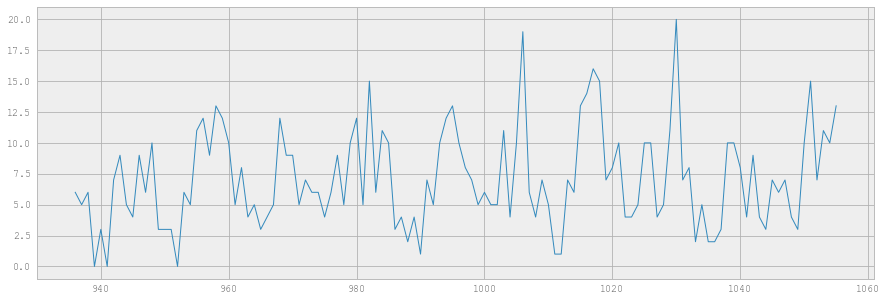

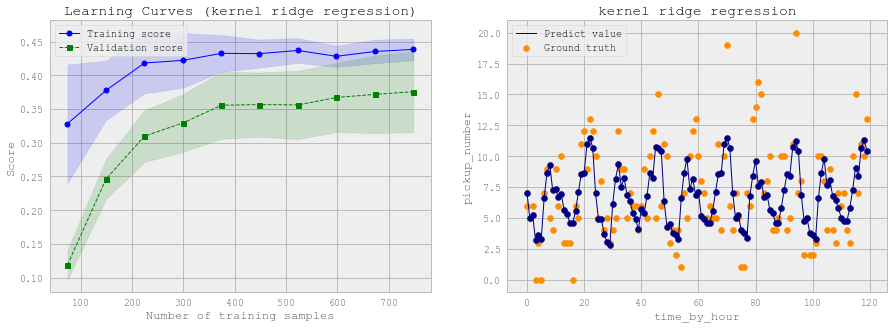

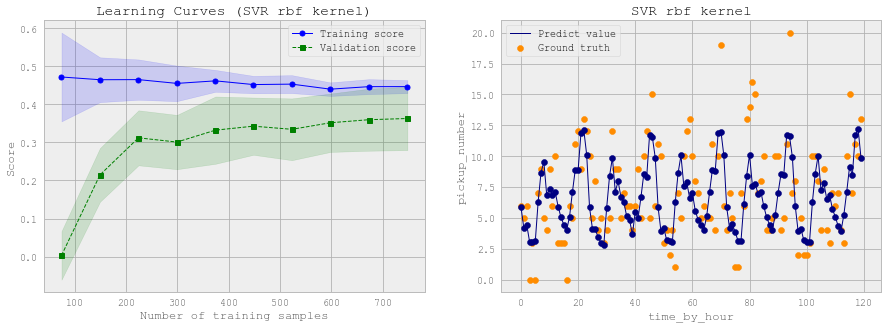

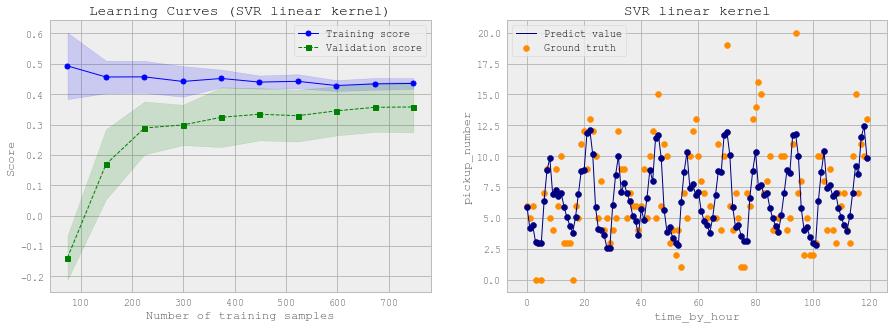

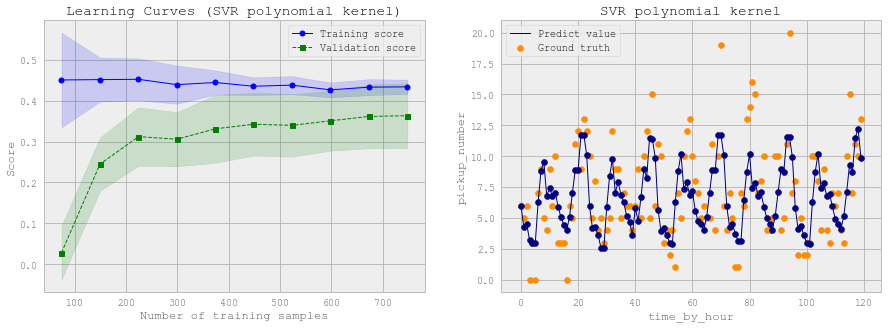

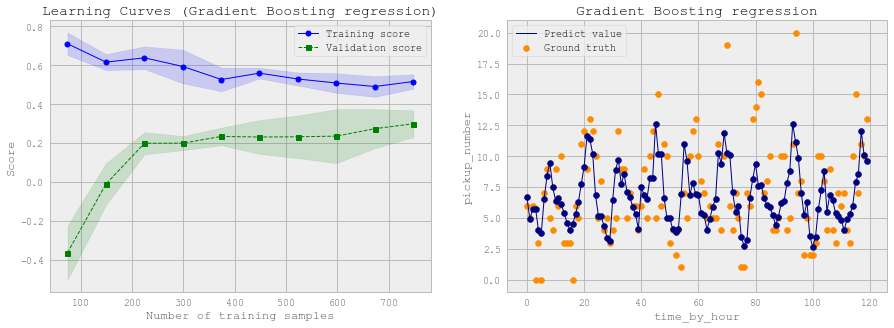

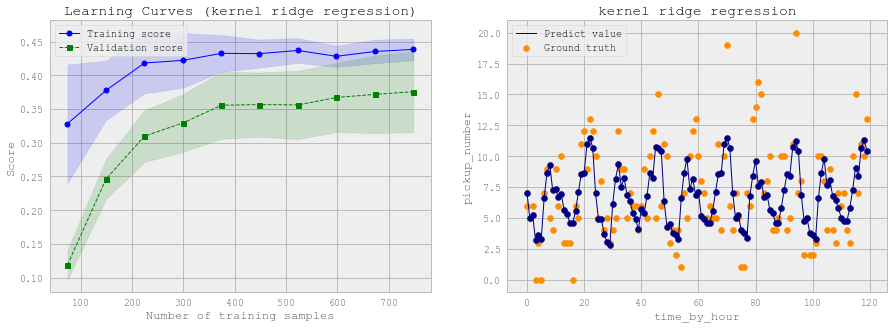

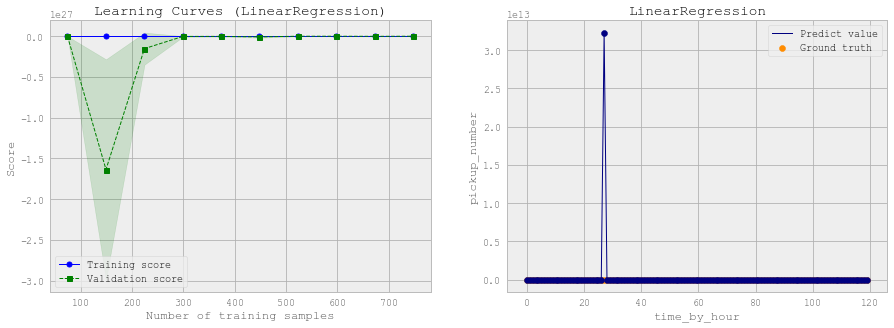

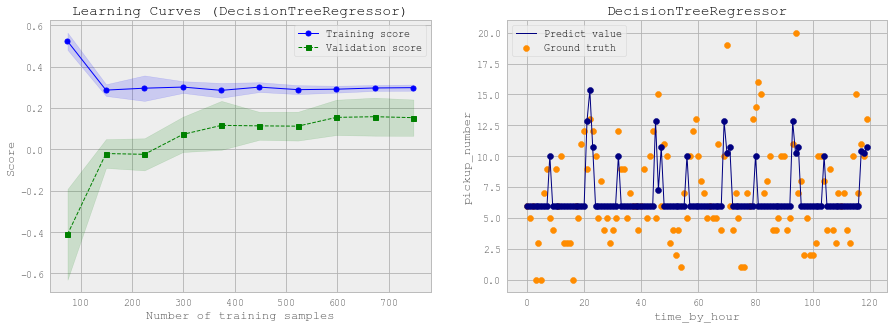

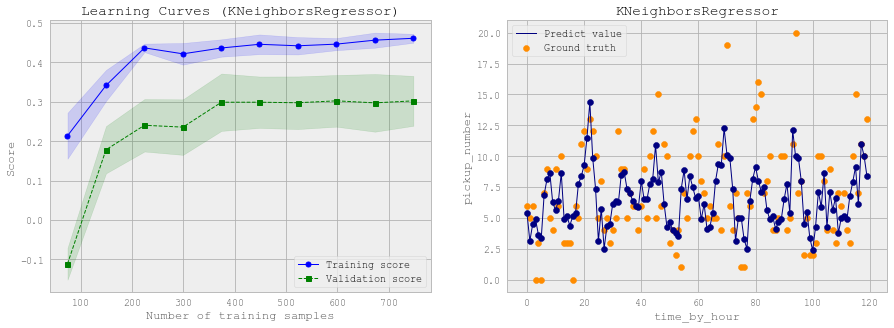

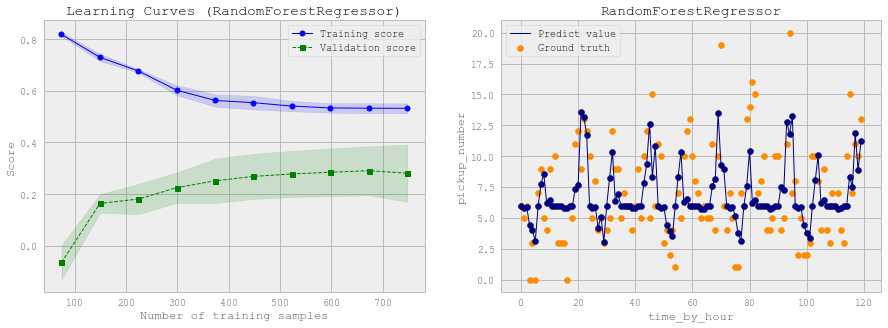

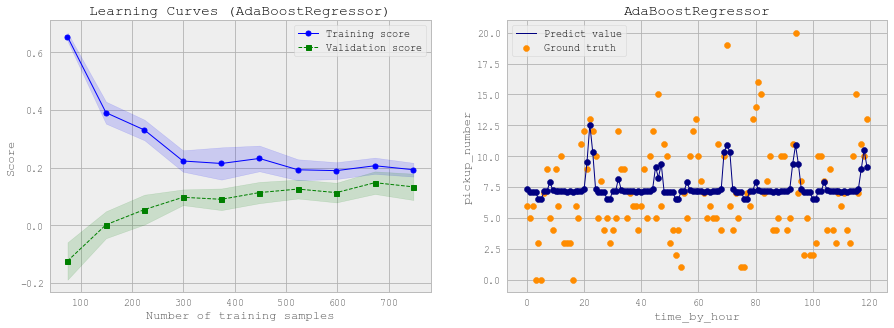

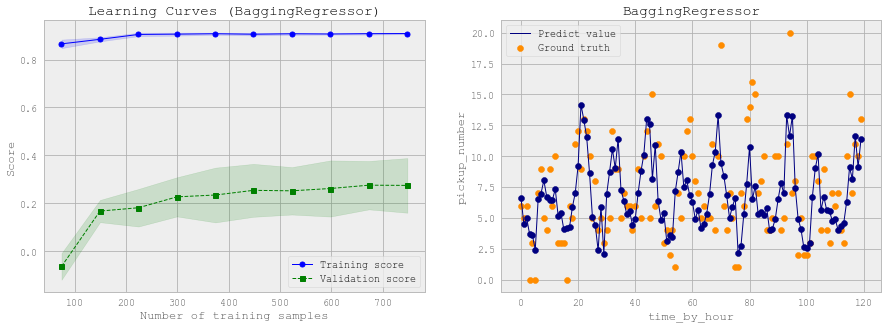

In [5]:
# train('./location/-73.99,40.763.csv')
# filename = './location/-73.99,40.763.csv'
# if './location' in filename:
#     filename = filename.split('/')[2]
# filename

Best Score: 0.0014
Parameters: {'C': 100, 'gamma': 0.01}
Best Score: -0.012
Parameters: {'C': 1000}
Best Score: -0.0072
Parameters: {'C': 100, 'degree': 2}
Best Score: -0.1533
Parameters: {'min_samples_split': 2, 'loss': 'lad', 'learning_rate': 0.01, 'n_estimators': 500, 'max_depth': 1}
Best Score: 0.0174
Parameters: {'alpha': 1.0, 'gamma': 0.01}
Best Score: -100
Parameters: 
Best Score: -0.0379
Parameters: {'max_depth': 2}
Best Score: -0.0951
Parameters: {'n_neighbors': 8}
Best Score: -0.0074
Parameters: {'n_estimators': 500, 'max_depth': 2}
Best Score: -0.3587
Parameters: {'n_estimators': 20}
Best Score: -0.1743
Parameters: {'n_estimators': 500}
model: kernel ridge regression


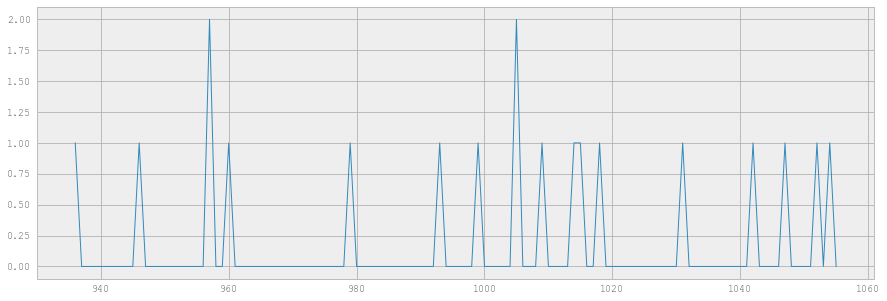

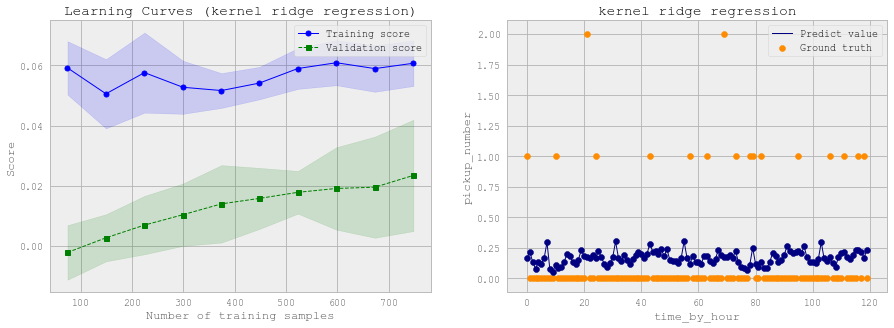

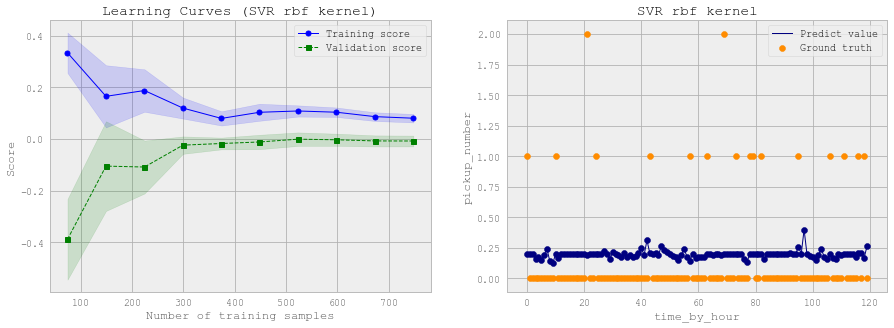

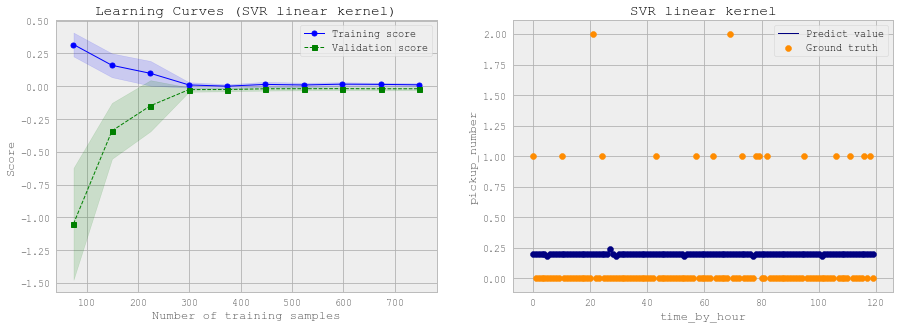

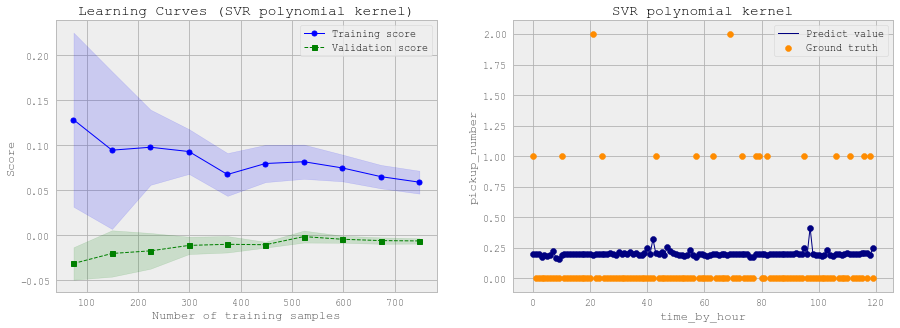

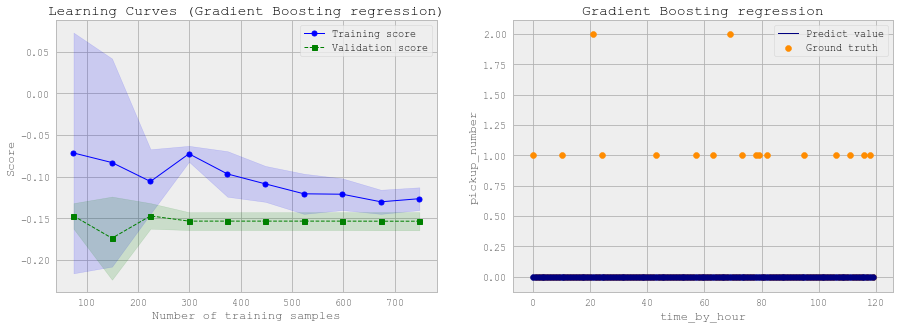

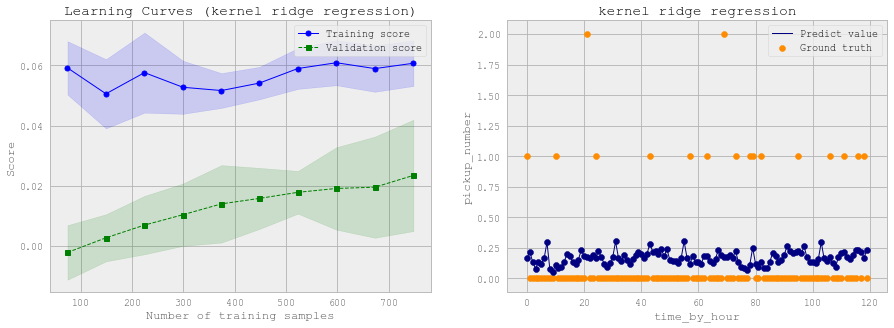

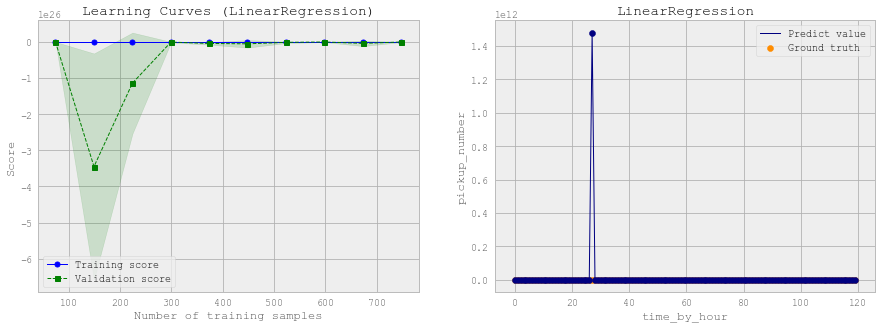

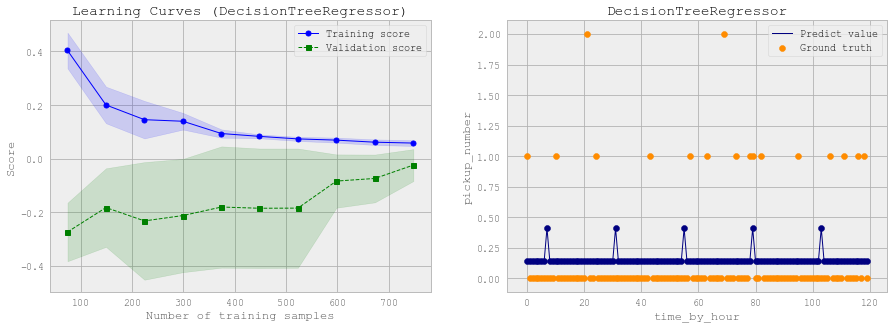

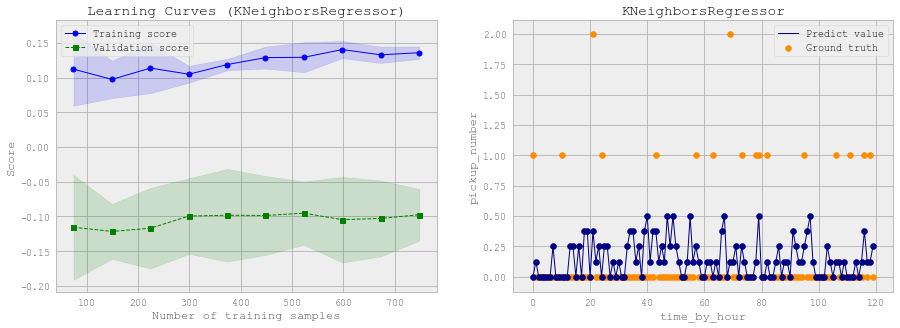

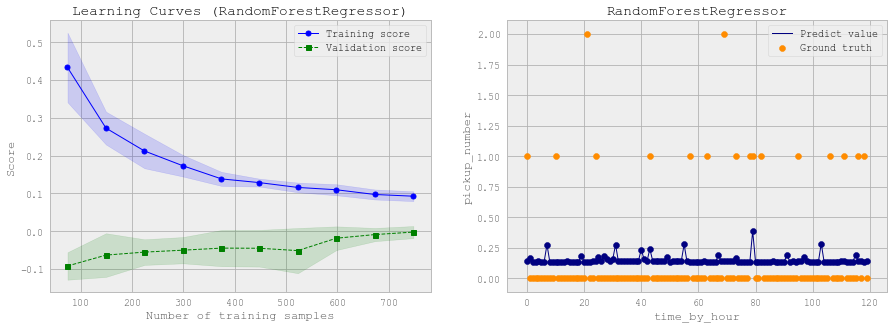

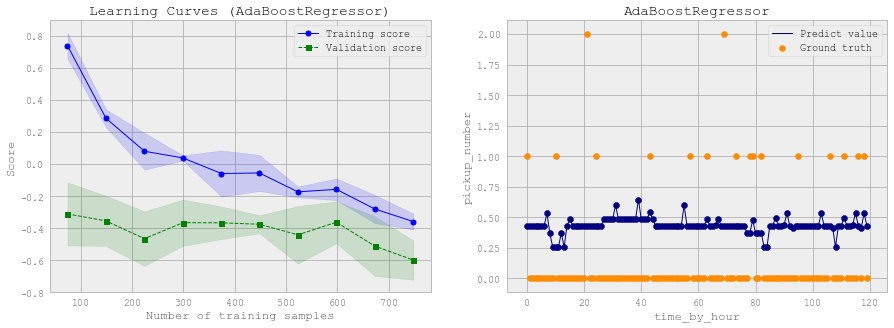

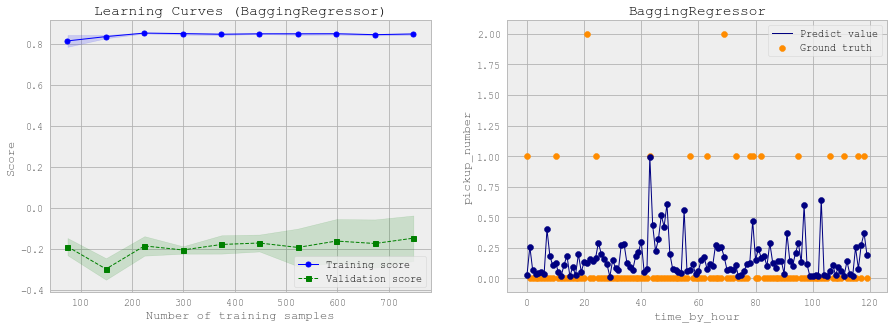

In [6]:
# train('./location/-73.925,40.866.csv')

Best Score: 0.7998
Parameters: {'C': 10, 'gamma': 0.01}
Best Score: 0.8024
Parameters: {'C': 1}
Best Score: 0.8031
Parameters: {'C': 100, 'degree': 1}
Best Score: 0.7999
Parameters: {'min_samples_split': 2, 'loss': 'lad', 'learning_rate': 0.1, 'n_estimators': 900, 'max_depth': 1}
Best Score: 0.8154
Parameters: {'alpha': 0.01, 'gamma': 0.01}
Best Score: -100
Parameters: 
Best Score: 0.6341
Parameters: {'max_depth': 8}
Best Score: 0.6776
Parameters: {'n_neighbors': 6}
Best Score: 0.7405
Parameters: {'n_estimators': 150, 'max_depth': 8}
Best Score: 0.4291
Parameters: {'n_estimators': 20}
Best Score: 0.7762
Parameters: {'n_estimators': 500}
model: kernel ridge regression


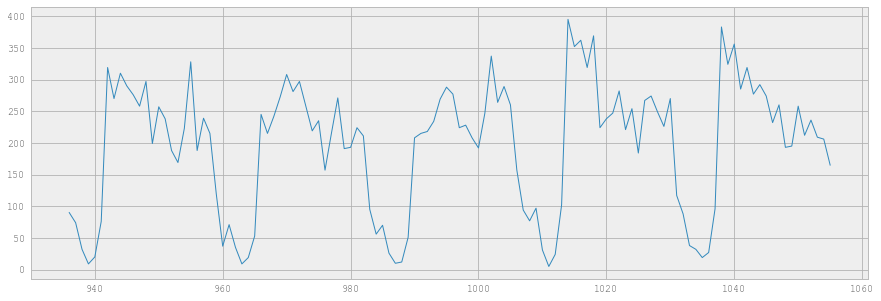

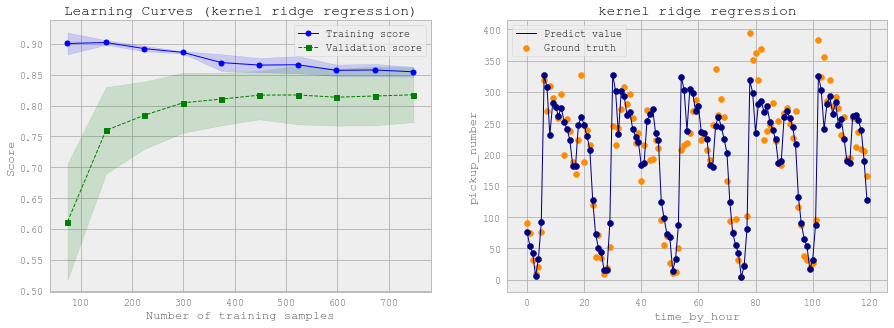

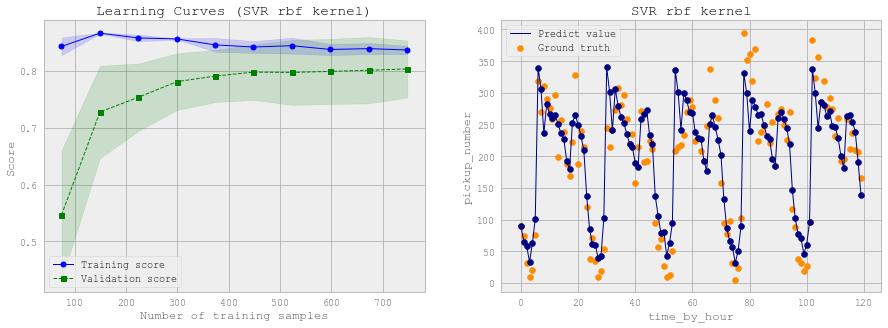

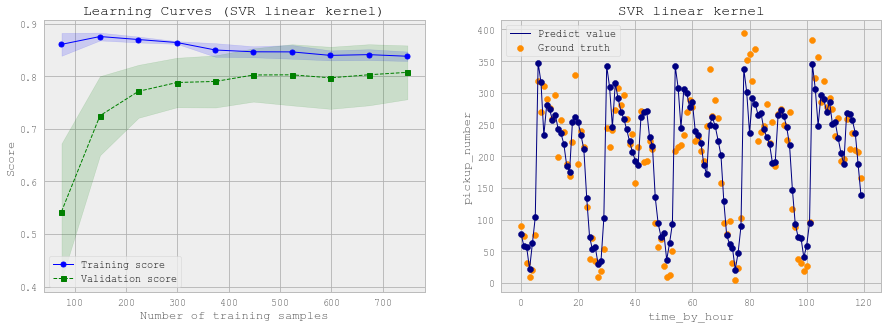

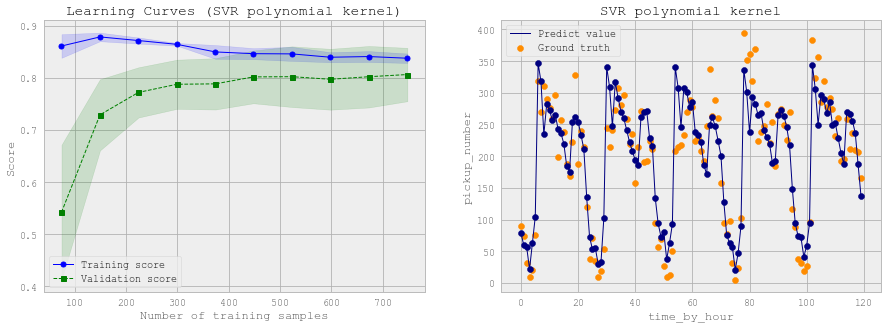

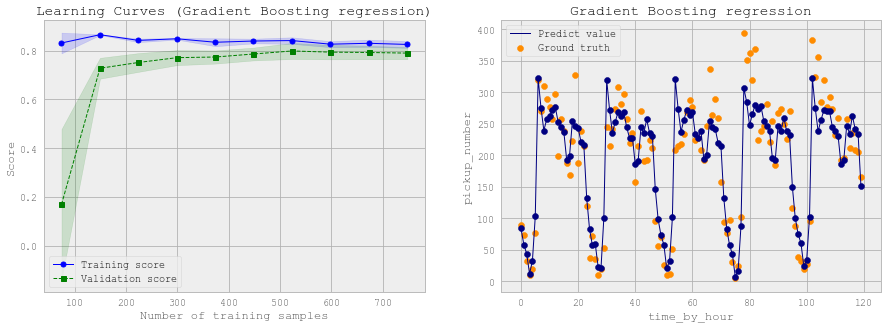

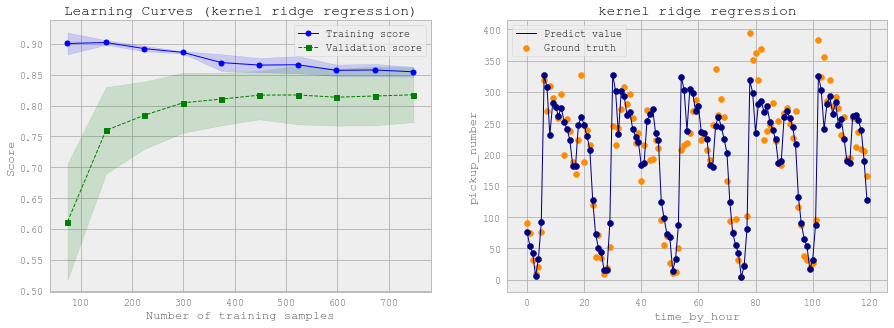

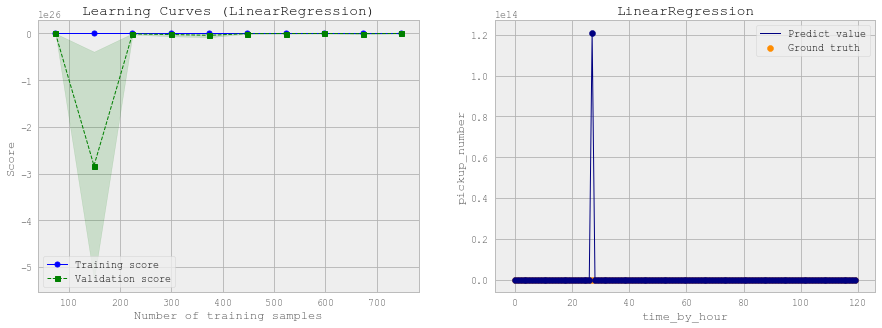

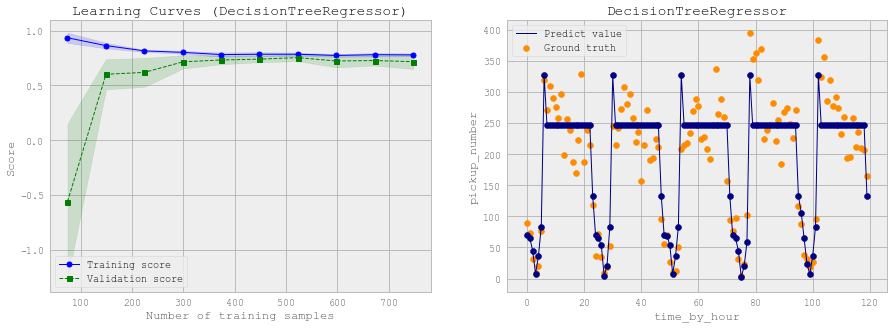

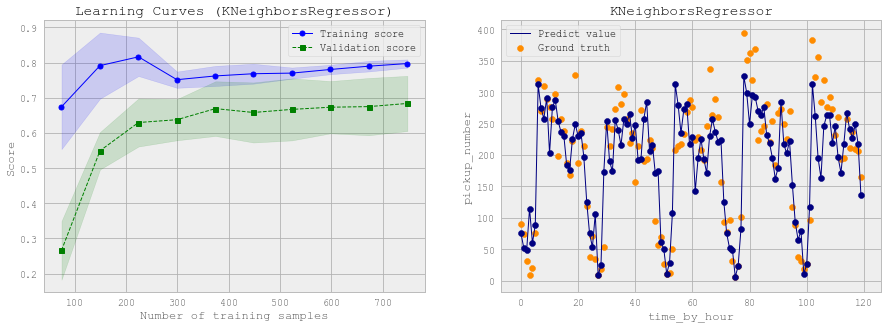

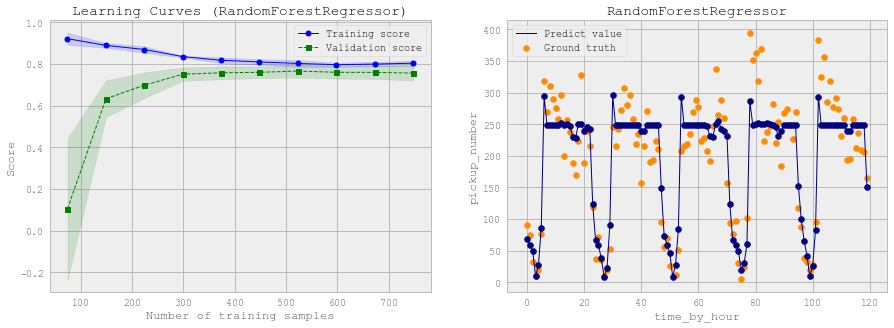

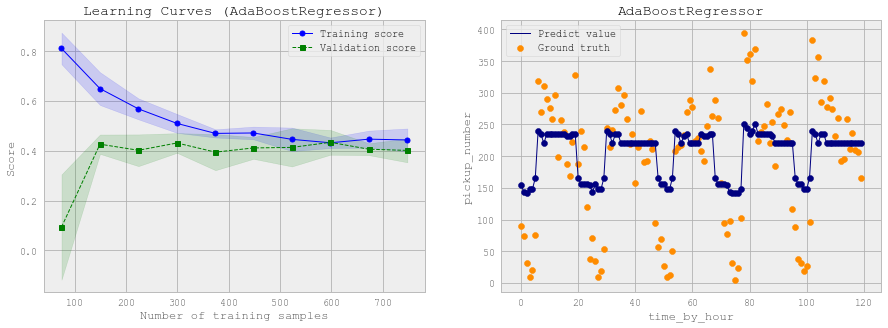

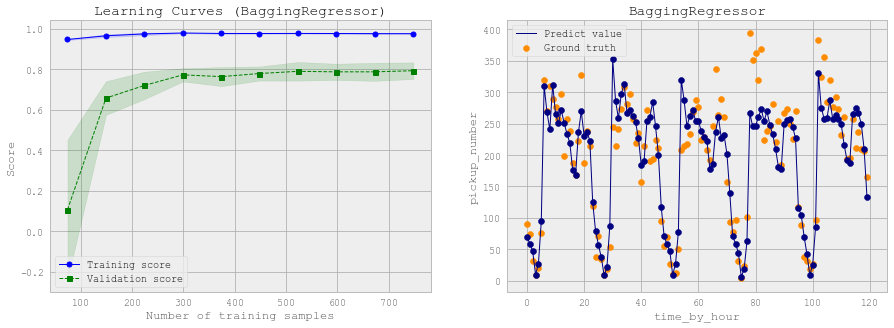

In [7]:
# train('./location/-73.994,40.751.csv')

In [4]:
# #############################################################################
def proInput(test, location=None):
    
    if location == None:
        location = 'train'
    path = './models/'
    with open(path+location+'_coefficient.js','r') as f:
        data=json.load(f)
        y_max, y_min, x_max, x_min = data['y_max'], data['y_min'], data['x_max'], data['x_min']
    
    # convert dictionary to dataframe
    df = pd.DataFrame.from_dict(test, orient='index').T
    df['Time'] = df['Time'].str.slice(0,-3)
    X = df[['Weather','Time']].copy()
    del df['Time']
    del df['Weather']

    X = [X.loc[index].to_dict() for index in X.index]
    vec = joblib.load(path+'vec.pkl')
    dummyX =vec.transform(X).toarray()
    X = pd.DataFrame(dummyX,columns=vec.get_feature_names())

    df.astype('float')
    data = np.array(df)
    data -= x_min
    data /= x_max
    data = pd.DataFrame(data)
    X = pd.DataFrame(dummyX,columns=vec.get_feature_names())
    X = data.join(X)
    return np.array(X)


# type(test)=dict
# test = Time	Temp	Weather	Wind	Humidity	Barometer	Visibility
def predict(test, location):
    
    if location == None:
        location = 'train'
    path = './models/'
    with open(path+location+'_coefficient.js','r') as f:
        data=json.load(f)
        y_max, y_min, x_max, x_min = data['y_max'], data['y_min'], data['x_max'], data['x_min']
        
    model = joblib.load(path + location + '.pkl')
    
    y_pred = model.predict(test)*y_max+y_min
    return y_pred.astype(np.int)
    
# test = {'Time':'18:59','Temp':64,'Weather':'Sunny','Wind':6,'Humidity':73,'Barometer':29.5,'Visibility':10}
# predict(proInput(test))

import os    
import csv

path = './models/'
result_path = './result/'
csvFile = open(result_path+'result_2016_05_03.csv','wb')
csvWriter = csv.writer(csvFile)
csvWriter.writerow(['Time', 'longitude', 'latitude', 'count'])
weather = pd.read_csv('./weather_2016_05_03.csv')

for i in range(len(weather)):
    test = weather.loc[i]
    test = test.to_dict()
    test['Time'] = test['Time'][3:]
    Time = test['Time'][:2]
    
    for f in os.listdir(path):
        if f.endswith(".js") and not f.startswith('train'):
            location = f[:-15]
            longitude, latitude = location.split(',')
            count = str(predict(proInput(test,location),location)[0])
            csvWriter.writerow([Time, longitude, latitude, count])
csvFile.close()            


In [31]:
csvFile.close()

AttributeError: 'str' object has no attribute 'close'

In [1]:
# # #############################################################################
# # generate data for every location
# import pandas as pd
# taxi1 = pd.read_csv(r'D:/Application/eclipse/workspace/COMSE6998PROJECT//PreProcessTaxiData/cleanData_yellow_tripdata_2016-03.csv')
# taxi2 = pd.read_csv(r'D:/Application/eclipse/workspace/COMSE6998PROJECT//PreProcessTaxiData/cleanData_yellow_tripdata_2016-04.csv')
# taxi = taxi1.append(taxi2)
# del taxi['Unnamed: 0']
# Time=taxi['tpep_pickup_datetime'].copy().str.slice(8,16)
# taxi['tpep_pickup_datetime']=Time.str.slice_replace(6,8,'51')

# gb = taxi.groupby(['pickup_longitude', 'pickup_latitude'])
# path = './location/'
# index_month = {'03': ['2016-03-'+str(i).zfill(2)+' '+str(j).zfill(2)+':51' for i in range(1,32) for j in range(24)],\
#                '04': ['2016-04-'+str(i).zfill(2)+' '+str(j).zfill(2)+':51' for i in range(1,31) for j in range(24)]}
# a=index_month['03']
# a.extend(index_month['04'])
# # remove weekends
# data = pd.DataFrame(a,index=a,columns=['tpep_pickup_datetime'])
# data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
# data['weekday'] = data['tpep_pickup_datetime'].dt.dayofweek
# data.index = data.index.str.slice(8,16)
# filt = data['weekday'] <= 4
# del data['weekday']
# # now filt is the filter of datetime which set weekends as False

# index_month = {'03': [str(i).zfill(2)+' '+str(j).zfill(2)+':51' for i in range(1,32) for j in range(24)],\
#                '04': [str(i).zfill(2)+' '+str(j).zfill(2)+':51' for i in range(1,31) for j in range(24)]}
# index = []
# for month in index_month:
#     index.extend(index_month[month])

# for x in gb:
#     filename = path+str(x[0][0])+','+str(x[0][1])+'.csv'
#     temp = pd.DataFrame([0 for i in range(len(index))],index=index,columns=['pickup_number'])
#     temp.index.names = ['Time']
#     e = x[1].groupby('tpep_pickup_datetime').size().reset_index(name='pickup_number')
#     e.index = e['tpep_pickup_datetime']
#     del e['tpep_pickup_datetime']
#     e.index.names = ['Time']
#     select_index = e.index
#     temp['pickup_number'].loc[select_index] = e['pickup_number'].loc[select_index]
#     temp = temp[filt]
#     temp.index = temp.index.str.slice(3,5)
#     temp.to_csv(filename)